In [35]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
from UtilDataframes import cvtTimestampIntoDatetimeIndex, split_date, add_n_last_periods, split_features_from_target
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from time import time

In [36]:
data = read_csv("../data/btc.csv")[:100]
data.drop('Unnamed: 0', axis=1)
data = data[['timestamp', 'Close']]
cvtTimestampIntoDatetimeIndex(data, 'timestamp')
data = data.asfreq(pd.infer_freq(data.index))
data

,Close
timestamp,
2021-09-14 03:21:00,45298.868508
2021-09-14 03:22:00,45348.035714
2021-09-14 03:23:00,45333.891429
2021-09-14 03:24:00,45277.501429
2021-09-14 03:25:00,45269.988333
...,...
2021-09-14 04:56:00,45045.547143
2021-09-14 04:57:00,45059.574286
2021-09-14 04:58:00,45074.532857


# Rolling Forecast Origin

**Consiste en predecir, como máximo, el periodo siguiente (t + 1), en base a todos periodos anteriores (desde el origen)**

## Vamos a establecer a partir de qué fecha queremos empezar a hacer las predicciones

In [37]:
train_end_date = datetime(2021, 9, 14, 4, 30, 0)
test_start_date = train_end_date + timedelta(seconds=60)

train_data = data[:train_end_date]
test_data = data[test_start_date:]
# test_data

## Si no hacemos rolling, los datos predichos se aproximaran a una especie de media de los datos reales...

<AxesSubplot:xlabel='timestamp'>

<Figure size 864x576 with 0 Axes>

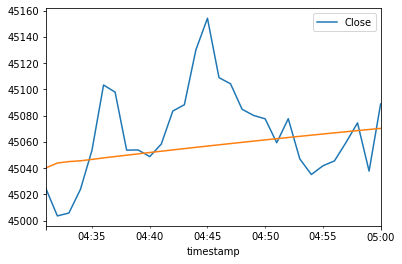

In [38]:
model = ARIMA(train_data, order=(3,0,0))
model_fit = model.fit()
predictions_no_rolling = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
plt.figure(figsize=(12,8))
test_data.plot()
predictions_no_rolling.plot()

## Como vemos, los datos predichos parecen más una media, que una predicción, esto es normal ya que estamos intentando predecir valores cada vez más lejos de los datos de entrenamiento. Justo para esto es para lo que usamos el Rolling Forecast Origin...

In [39]:
one_minute = timedelta(seconds=60)
predictions_rolling = pd.Series(dtype=float)
for end_date in test_data.index:
    train_data = data[:end_date - one_minute]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    prediction = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = prediction[0]

<AxesSubplot:xlabel='timestamp'>

<Figure size 864x576 with 0 Axes>

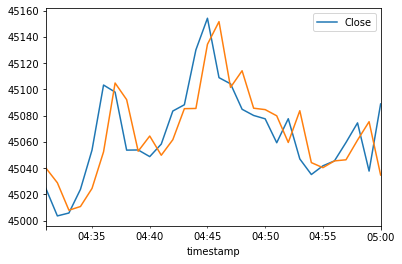

In [40]:
plt.figure(figsize=(12,8))
test_data.plot()
predictions_rolling.plot()

## Observamos como el modelo se ajusta bastante más a los datos reales que cuando no  hacemos rolling forecasting

# Vamos ahora a echar un vistazo a los residuos de ambos modelos, con y sin rolling

**Recordemos que la forma de los residuos nos da información acerca de cómo lo hemos hecho con nuestro modelo, si se observa alguna tendencia en estos, nos está diciendo que hay algún factor que no hemos sido capaces de modelar bien, sin embargo, unos residuos que sean White Noise, son una buena señal de que hemos conseguido capturar correctamente las dinámicas de la serie temporal en nuestro modelo**

<AxesSubplot:xlabel='timestamp'>

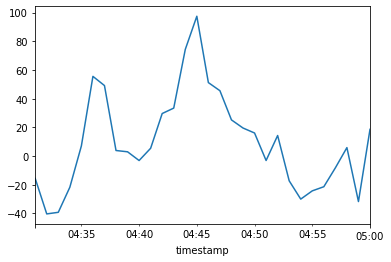

In [48]:
residuals_no_rolling = test_data['Close'] - predictions_no_rolling
plt.figure(figsize=(6,4))
residuals_no_rolling.plot()

<AxesSubplot:xlabel='timestamp'>

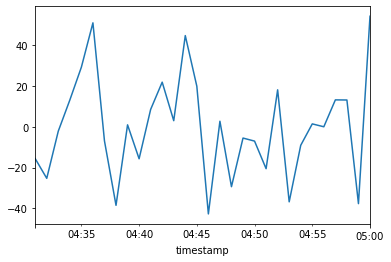

In [49]:
residuals_rolling = test_data['Close'] - predictions_rolling
plt.figure(figsize=(6,4))
residuals_rolling.plot()

## Vemos como los residuos en el modelo con rolling son mucho más ruidosos que los del modelo sin rolling, como hemos explicado arriba, esto es bueno, debido a que hemos conseguido modelar mejor la variación de la serie